<a href="https://colab.research.google.com/github/MilanBandara/FYP/blob/main/UNET_for_Deblur_PNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import numpy as np
# from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda,Resizing
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import to_categorical

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Creating the data generator

In [4]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(img_dir+"/"+image_name,0)
            # print(img_dir+"/"+image_name)
            image = cv2.resize(image,(256,256))
            # print("Image - ",image.shape)
            images.append(image)
    images = np.array(images)

    return(images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples
            batch_start += batch_size
            batch_end += batch_size

def test_imageLoader(img_dir, img_list,batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])

            yield (X) #a tuple with two numpy arrays with batch_size samples
            batch_start += batch_size
            batch_end += batch_size

# Making the data generator

In [5]:
train_X_dir = r"F:\FYP\FYP\BRATS_training_data\Corrupted"
train_Y_dir = r"F:\FYP\FYP\BRATS_training_data\Original"

train_X_list=sorted(os.listdir(train_X_dir))
train_X_list = train_X_list[:3500]
train_Y_list = sorted(os.listdir(train_Y_dir))
train_Y_list = train_Y_list[:3500]

val_X_dir = r"F:\FYP\FYP\BRATS_val_data\Corrupted"
val_Y_dir = r"F:\FYP\FYP\BRATS_val_data\Original"
val_X_list = sorted(os.listdir(val_X_dir))
val_X_list = val_X_list[:500]
val_Y_list = sorted(os.listdir(val_Y_dir))
val_Y_list = val_Y_list[:500]
# test_X_dir = r"F:\FYP\FYP\BRATS_training_data\Corrupted"
# test_X_list = sorted(os.listdir(test_X_dir))

In [6]:
batch_size = 8

train_img_datagen = imageLoader(train_X_dir, train_X_list,
                                train_Y_dir, train_Y_list, batch_size)

val_img_datagen = imageLoader(val_X_dir, val_X_list,
                                val_Y_dir, val_Y_list, batch_size)
                                

In [7]:
# batch_size = 8
# test_img_datagen = test_imageLoader(test_X_dir,test_X_list,batch_size)

# Verifying the generator

In [8]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

In [9]:
# test_img = test_img_datagen.__next__()
# index = 3
# plt.subplot(121)
# plt.imshow(test_img[index],cmap="gray")

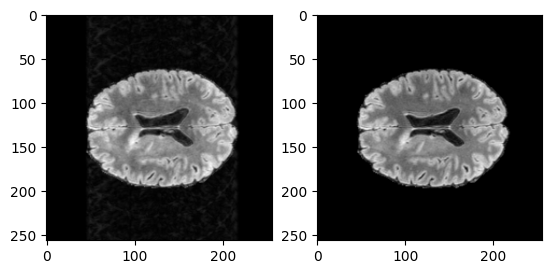

In [10]:
img, msk = train_img_datagen.__next__()
index = 3
plt.subplot(121)
plt.imshow(img[index],cmap="gray")
plt.subplot(122)
plt.imshow(msk[index],cmap="gray")

# CBAM attention

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply

"""
Implementation of CBAM: Convolutional Block Attention Module in the TensorFlow 2.5.
Paper: https://arxiv.org/pdf/1807.06521
"""

def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

# def spatial_attention_module(x):
#     ## Average Pooling
#     x1 = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)

#     ## Max Pooling
#     x2 = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)

#     ## Concatenate both the features
#     feats = Concatenate(axis=-1)([x1, x2])
#     ## Conv layer
#     feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
#     feats = Multiply()([x, feats])

#     return feats
    
def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

# Basic UNET model

In [12]:
def multi_unet_model():
#Build the model
    inputs = Input((256, 256, 1))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name = "c11_conv")(s)
    c1 = Dropout(0.3,name="c1_drop")(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c12_conv")(c1)
    p1 = MaxPooling2D((2, 2),name="p1")(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c21_conv")(p1)
    c2 = Dropout(0.3,name="c2_drop")(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c22_conv")(c2)
    p2 = MaxPooling2D((2, 2),name="p2")(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c31_conv")(p2)
    c3 = Dropout(0.4,c3_drop)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c32_conv")(c3)
    p3 = MaxPooling2D((2, 2),name="p3")(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c41_conv")(p3)
    c4 = Dropout(0.4,name="c4_drop")(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c42_conv")(c4)
    p4 = MaxPooling2D(pool_size=(2, 2),name="p4")(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c51_conv")(p4)
    c5 = Dropout(0.5,name="c5_drop")(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c52_conv")(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.4)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.4)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.3)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='relu')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

# Unet with CBAM attention

In [13]:
def attention_unet():
#Build the model
    inputs = Input((256, 256, 1))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name = "c11_conv")(s)
    c1 = Dropout(0.3,name="c1_drop")(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c12_conv")(c1)
    p1 = MaxPooling2D((2, 2),name="p1")(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c21_conv")(p1)
    c2 = Dropout(0.3,name="c2_drop")(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c22_conv")(c2)
    p2 = MaxPooling2D((2, 2),name="p2")(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c31_conv")(p2)
    c3 = Dropout(0.4,name="c3_drop")(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c32_conv")(c3)
    p3 = MaxPooling2D((2, 2),name="p3")(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c41_conv")(p3)
    c4 = Dropout(0.4,name="c4_drop")(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c42_conv")(c4)
    p4 = MaxPooling2D((2, 2),name="p4")(c4)#?????????????????????

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c51_conv")(p4)
    c5 = Dropout(0.5,name="c5_drop")(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name="c52_conv")(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    skip4 = cbam(c4)
    u6 = concatenate([u6, skip4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.4)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    skip3 = cbam(c3)
    u7 = concatenate([u7, skip3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.4)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    skip2 = cbam(c2)
    u8 = concatenate([u8, skip2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    skip1 = cbam(c1)
    u9 = concatenate([u9, skip1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.3)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='relu')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

# Multi Resolution UNET

In [14]:
def multi_res_attention_unet():
#Build the model
    inputs = Input((256, 256, 1))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.3)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

#############################################################################################################
    input2 = Resizing(128, 128, name='resizing_to_128')(s)
    ci2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input2)
    ci2 = Dropout(0.3)(ci2)
    b02_concat = concatenate([ci2, p1])
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b02_concat)
    c2 = Dropout(0.3)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
###############################################################################################################
    input3 = Resizing(64, 64, name='resizing_to_64')(s)
    ci3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input3)
    ci3 = Dropout(0.3)(ci3)
    b03_concat = concatenate([ci3, p2])

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b03_concat)
    c3 = Dropout(0.4)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
################################################################################################################
    input4 = Resizing(32, 32, name='resizing_to_32')(s)
    ci4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input4)
    ci4 = Dropout(0.3)(ci4)
    b04_concat = concatenate([ci4, p3])


    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b04_concat)
    c4 = Dropout(0.4)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
#################################################################################################################
    input5 = Resizing(16, 16, name='resizing_to_16')(s)
    ci5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input5)
    ci5 = Dropout(0.3)(ci5)
    b05_concat = concatenate([ci5, p4])


    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b05_concat)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    skip4 = cbam(c4)
    u6 = concatenate([u6, skip4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.4)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    skip3 = cbam(c3)
    u7 = concatenate([u7, skip3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.4)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    skip2 = cbam(c2)
    u8 = concatenate([u8, skip2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    skip1 = cbam(c1)
    u9 = concatenate([u9, skip1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.3)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='relu')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

# Creating a Checkpoint

In [15]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = r"F:\FYP\FYP\Final_notebook\checkpiont/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Calculate the number of batches per epoch
import math
n_batches = 3900 / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=10*n_batches)

# Tensorboard

In [16]:
from tensorflow.keras.callbacks import TensorBoard
file_name = 'CBAM_with_more_data'  #Give unique name each time, otherwise results get concatenated
#Try running multiple times and see the output in tensorboard
#If file name is changed, you can select the specific model in TensorBoard

tensorboard = TensorBoard(log_dir="logs\\{}".format(file_name))

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

IMG_HEIGHT = 256
IMG_WIDTH  =  256
IMG_CHANNELS = 4

# model = multi_unet_model()
model = attention_unet()
model.compile(optimizer=Adam(), loss=MeanSquaredError())
#model.compile(optimizer='adam', loss=ca, metrics=[accuracy])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 c11_conv (Conv2D)              (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 c1_drop (Dropout)              (None, 256, 256, 16  0           ['c11_conv[0][0]']               
                                )                                                             

In [18]:
steps_per_epoch = len(train_X_list)//batch_size
val_steps_per_epoch = len(val_X_list)//batch_size

In [19]:
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    epochs=106,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[cp_callback,tensorboard],
                    shuffle=True)

Epoch 1/106
171/437 [==========>...................] - ETA: 2:27 - loss: 538.1536

KeyboardInterrupt: 

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
for i in history.history.items():
  print(i)

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
np.save("/content/drive/MyDrive/deblur_results/training_loss.npy",np.array(loss))
np.save("/content/drive/MyDrive/deblur_results/val_loss.npy",np.array(val_loss))
np.save("/content/drive/MyDrive/focal5/training_jaccard.npy",np.array(acc))
np.save("/content/drive/MyDrive/focal5/val_jaccard.npy",np.array(val_acc))
np.save("/content/drive/MyDrive/focal5/epochs.npy",range(1, len(np.array(loss)) + 1))

In [ ]:
# loss_1 = np.load("/content/drive/MyDrive/small_UNET_models/training_loss.npy")
# epoch_1 = np.load("/content/drive/MyDrive/small_UNET_models/epochs.npy")

# plt.plot(epoch_1, loss_1, 'y', label='Training loss')
# # plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [ ]:
img, msk = val_img_datagen.__next__()

## making predictions on val dataset

In [ ]:
img, msk = val_img_datagen.__next__()
import random
test_img_number = random.randint(0, len(img)-1)#6 is good
# test_img_number = 6
test_img = img[test_img_number]
ground_truth=msk[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
prediction = np.reshape(prediction,(256,256))
print(test_img.shape)
print(ground_truth.shape)


plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray') #only the first channel is displayed

plt.subplot(132)
plt.title('Original Label')
plt.imshow(ground_truth, cmap='gray')

plt.subplot(133)
plt.title('Predicted ')
plt.imshow(prediction, cmap='gray')
plt.show()

## Loading the last checkpoint

In [20]:
# Load the previously saved weights
model.load_weights(r"F:\FYP\FYP\Final_notebook\checkpiont/cp-0068.ckpt")

In [21]:
img, msk = val_img_datagen.__next__()

1/1 [==============================] - 0s 26ms/step
(256, 256)
(256, 256)


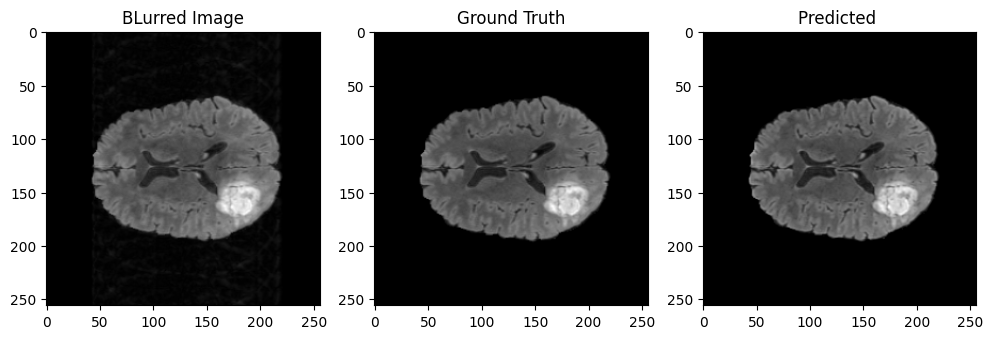

In [29]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')
img, msk = val_img_datagen.__next__()
import random
test_img_number = random.randint(0, len(img)-1)
# test_img_number = 6
test_img = img[test_img_number]
ground_truth=msk[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
prediction = np.reshape(prediction,(256,256))
print(test_img.shape)
print(ground_truth.shape)


plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('BLurred Image')
plt.imshow(test_img, cmap='gray') #only the first channel is displayed

plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='gray')

plt.subplot(133)
plt.title('Predicted ')
plt.imshow(prediction, cmap='gray')
plt.show()

# focal_loss = FocalLoss()
# loss = focal_loss.call(ground_truth, predicted_img)
# print(loss)
# # IOU = jacard_coef(ground_truth, predicted_img)
# # print(IOU)

# Testing on test set

In [ ]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')
img = test_img_datagen.__next__()
import random
test_img_number = random.randint(0, len(img)-1)
# test_img_number = 6
test_img = img[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
prediction = np.reshape(prediction,(256,256))
print(test_img.shape)


plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.title('BLurred Image')
plt.imshow(test_img, cmap='gray') #only the first channel is displayed

plt.subplot(122)
plt.title('Predicted ')
plt.imshow(prediction, cmap='gray')
plt.show()

# Start training from a checkpoint

In [ ]:
steps_per_epoch = len(train_X_list)//batch_size
val_steps_per_epoch = len(val_X_list)//batch_size

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = r"H:\FYP\checkpiont2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Calculate the number of batches per epoch
import math
n_batches = 5000 / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=10*n_batches)

In [ ]:
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    epochs=70,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[cp_callback_2],
                    shuffle=False)